# Model Performance Evaluation and Visualization

This notebook evaluates the performance of a classification model using predictions and ground truth data from CSV files. It calculates various metrics and visualizes the results.

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import (
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score, 
    balanced_accuracy_score, 
    matthews_corrcoef, 
    confusion_matrix, 
    classification_report, 
    cohen_kappa_score
)
import matplotlib.pyplot as plt
import seaborn as sns

## 1. Configuration
Define the paths to the prediction and ground truth files, and list the class names.

In [2]:
# Path to files
predictions_file = '/home/nqmtien/REIT4841/rag_cbm/predictions_gemma_4b.csv'
ground_truth_file = '/home/nqmtien/REIT4841/rag_cbm/isic_2018_task3/data/validation_ground_truth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv'

# Extract class names
classes = ['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC']

## 2. Load Data
Load the predictions and ground truth data from the specified CSV files.

In [3]:
predictions_df = pd.read_csv(predictions_file)
ground_truth_df = pd.read_csv(ground_truth_file)

print("Predictions Data Head:")
print(predictions_df.head())
print("\nGround Truth Data Head:")
print(ground_truth_df.head())

Predictions Data Head:
          image  MEL   NV  BCC  AKIEC  BKL   DF  VASC
0  ISIC_0034413  0.0  0.0  0.0    0.0  0.0  0.0   1.0
1  ISIC_0034368  1.0  0.0  0.0    0.0  0.0  0.0   0.0
2  ISIC_0034406  1.0  0.0  0.0    0.0  0.0  0.0   0.0
3  ISIC_0034342  1.0  0.0  0.0    0.0  0.0  0.0   0.0
4  ISIC_0034412  1.0  0.0  0.0    0.0  0.0  0.0   0.0

Ground Truth Data Head:
          image  MEL   NV  BCC  AKIEC  BKL   DF  VASC
0  ISIC_0034321  0.0  1.0  0.0    0.0  0.0  0.0   0.0
1  ISIC_0034322  0.0  1.0  0.0    0.0  0.0  0.0   0.0
2  ISIC_0034323  0.0  0.0  1.0    0.0  0.0  0.0   0.0
3  ISIC_0034324  0.0  1.0  0.0    0.0  0.0  0.0   0.0
4  ISIC_0034325  0.0  1.0  0.0    0.0  0.0  0.0   0.0


## 3. Merge Data
Merge the prediction and ground truth DataFrames based on the 'image' column to align the data for comparison.

In [4]:
# Merge on image ID to ensure we're comparing the same images
merged_df = predictions_df.merge(ground_truth_df, on='image')

print("Merged Data Head:")
print(merged_df.head())

Merged Data Head:
          image  MEL_x  NV_x  BCC_x  AKIEC_x  BKL_x  DF_x  VASC_x  MEL_y  \
0  ISIC_0034413    0.0   0.0    0.0      0.0    0.0   0.0     1.0    0.0   
1  ISIC_0034368    1.0   0.0    0.0      0.0    0.0   0.0     0.0    0.0   
2  ISIC_0034406    1.0   0.0    0.0      0.0    0.0   0.0     0.0    0.0   
3  ISIC_0034342    1.0   0.0    0.0      0.0    0.0   0.0     0.0    0.0   
4  ISIC_0034412    1.0   0.0    0.0      0.0    0.0   0.0     0.0    0.0   

   NV_y  BCC_y  AKIEC_y  BKL_y  DF_y  VASC_y  
0   0.0    0.0      0.0    1.0   0.0     0.0  
1   0.0    0.0      0.0    1.0   0.0     0.0  
2   0.0    1.0      0.0    0.0   0.0     0.0  
3   1.0    0.0      0.0    0.0   0.0     0.0  
4   1.0    0.0      0.0    0.0   0.0     0.0  


## 4. Extract True and Predicted Labels
Iterate through the merged data to extract the true labels (from ground truth) and predicted labels. The labels are assumed to be in a one-hot encoded format in the CSVs.

In [5]:
y_true = []
y_pred = []

# Extract and convert one-hot encoding to class indices
for idx, row in merged_df.iterrows():
    # Find true label (ground truth)
    true_label = None
    for category in classes:
        if row[f'{category}_y'] == 1.0:  # _y suffix for ground truth
            true_label = category
            break
    
    # Find predicted label
    pred_label = None
    for category in classes:
        if row[f'{category}_x'] == 1.0:  # _x suffix for predictions
            pred_label = category
            break
    
    if true_label is None:
        print(f"Warning: No true label found for row {idx}, image: {row['image']}")
    if pred_label is None:
        print(f"Warning: No predicted label found for row {idx}, image: {row['image']}")
        
    y_true.append(true_label)
    y_pred.append(pred_label)

# Filter out None values if any warnings occurred, to prevent errors in sklearn metrics
y_true_filtered = [lbl for lbl in y_true if lbl is not None]
y_pred_filtered = [y_pred[i] for i, lbl in enumerate(y_true) if lbl is not None]
y_pred_filtered = [lbl for i, lbl in enumerate(y_pred_filtered) if y_pred[i] is not None] # ensure y_pred also filtered
y_true_filtered = [y_true_filtered[i] for i, lbl in enumerate(y_pred_filtered) if lbl is not None]


print(f"Number of samples: {len(y_true_filtered)}")
print("First 5 true labels:", y_true_filtered[:5])
print("First 5 predicted labels:", y_pred_filtered[:5])

Number of samples: 193
First 5 true labels: ['BKL', 'BKL', 'BCC', 'NV', 'NV']
First 5 predicted labels: ['VASC', 'MEL', 'MEL', 'MEL', 'MEL']


## 5. Prepare Labels for Metrics
Convert the string labels to numerical indices, which are required by some scikit-learn metrics.

In [6]:
class_to_idx = {cls: i for i, cls in enumerate(classes)}
y_true_idx = [class_to_idx[lbl] for lbl in y_true_filtered if lbl in class_to_idx]
y_pred_idx = [class_to_idx[lbl] for lbl in y_pred_filtered if lbl in class_to_idx]

# Ensure that y_true_idx and y_pred_idx have the same length after potential filtering
min_len = min(len(y_true_idx), len(y_pred_idx))
y_true_idx = y_true_idx[:min_len]
y_pred_idx = y_pred_idx[:min_len]
# Update y_true_filtered and y_pred_filtered to match the indexed versions for consistency in reports
y_true_report = [classes[i] for i in y_true_idx]
y_pred_report = [classes[i] for i in y_pred_idx]


print("First 5 true label indices:", y_true_idx[:5])
print("First 5 predicted label indices:", y_pred_idx[:5])

First 5 true label indices: [4, 4, 2, 1, 1]
First 5 predicted label indices: [6, 0, 0, 0, 0]


## 6. Calculate and Display Overall Metrics
Compute and print overall performance metrics:
- Accuracy
- Balanced Accuracy
- Cohen's Kappa
- Matthews Correlation Coefficient

In [7]:
print('ISIC 2018 Task 3 - Skin Lesion Classification Evaluation')
print('-' * 60)
print(f'Total samples processed: {len(y_true_idx)}')

if len(y_true_idx) > 0:
    # Overall accuracy
    accuracy = accuracy_score(y_true_report, y_pred_report)
    print(f'\nOverall Accuracy: {accuracy:.4f}')

    # Balanced accuracy (accounts for class imbalance)
    balanced_acc = balanced_accuracy_score(y_true_idx, y_pred_idx)
    print(f'Balanced Accuracy: {balanced_acc:.4f}')

    # Cohen's Kappa (agreement level)
    kappa = cohen_kappa_score(y_true_report, y_pred_report)
    print(f"Cohen's Kappa: {kappa:.4f}")

    # Matthews Correlation Coefficient
    mcc = matthews_corrcoef(y_true_idx, y_pred_idx)
    print(f'Matthews Correlation Coefficient: {mcc:.4f}')
else:
    print("\nNo valid samples found to calculate metrics.")

ISIC 2018 Task 3 - Skin Lesion Classification Evaluation
------------------------------------------------------------
Total samples processed: 193

Overall Accuracy: 0.2228
Balanced Accuracy: 0.2537
Cohen's Kappa: -0.0352
Matthews Correlation Coefficient: -0.0466


## 7. Display Classification Report
Generate and print a detailed classification report, which includes precision, recall, and F1-score for each class.

In [8]:
if len(y_true_idx) > 0:
    print('\nClass-wise Performance:')
    try:
        class_report = classification_report(y_true_report, y_pred_report, target_names=classes, digits=4, zero_division=0)
        print(class_report)
    except ValueError as e:
        print(f"Could not generate classification report: {e}")
        print("This might happen if some classes are not present in y_true or y_pred after filtering.")
        print("Unique true labels:", np.unique(y_true_report))
        print("Unique pred labels:", np.unique(y_pred_report))

else:
    print("\nNo valid samples to generate classification report.")


Class-wise Performance:
              precision    recall  f1-score   support

         MEL     0.0000    0.0000    0.0000         8
          NV     0.0000    0.0000    0.0000        15
         BCC     0.0000    0.0000    0.0000        22
       AKIEC     0.1429    1.0000    0.2500         1
         BKL     0.0991    0.5238    0.1667        21
          DF     0.5536    0.2520    0.3464       123
        VASC     0.0000    0.0000    0.0000         3

    accuracy                         0.2228       193
   macro avg     0.1136    0.2537    0.1090       193
weighted avg     0.3643    0.2228    0.2402       193



## 8. Calculate and Display Averaged Metrics
Compute and print precision, recall, and F1-score using different averaging strategies (micro, macro, weighted) to understand overall model performance across all classes.

In [9]:
if len(y_true_idx) > 0:
    print('\nMulti-class Metrics with Different Averaging Strategies:')
    for avg in ['micro', 'macro', 'weighted']:
        precision = precision_score(y_true_report, y_pred_report, average=avg, zero_division=0)
        recall = recall_score(y_true_report, y_pred_report, average=avg, zero_division=0)
        f1 = f1_score(y_true_report, y_pred_report, average=avg, zero_division=0)
        print(f'  {avg.capitalize()} averaging:')
        print(f'    Precision: {precision:.4f}')
        print(f'    Recall: {recall:.4f}')
        print(f'    F1-score: {f1:.4f}')
else:
    print("\nNo valid samples to calculate averaged metrics.")


Multi-class Metrics with Different Averaging Strategies:
  Micro averaging:
    Precision: 0.2228
    Recall: 0.2228
    F1-score: 0.2228
  Macro averaging:
    Precision: 0.1136
    Recall: 0.2537
    F1-score: 0.1090
  Weighted averaging:
    Precision: 0.3643
    Recall: 0.2228
    F1-score: 0.2402


## 9. Calculate Confusion Matrix
Compute the confusion matrix to see how many samples were correctly and incorrectly classified for each class.

In [10]:
if len(y_true_idx) > 0:
    cm = confusion_matrix(y_true_idx, y_pred_idx, labels=list(range(len(classes))))
    print('\nConfusion Matrix:')
    print(cm)
else:
    cm = np.zeros((len(classes), len(classes)), dtype=int) # Empty matrix
    print("\nNo valid samples to compute confusion matrix.")


Confusion Matrix:
[[11  9  0  0  0  1  0]
 [73 31  0  0  0  2 17]
 [ 8  4  0  0  0  2  1]
 [ 5  3  0  0  0  0  0]
 [13  7  0  0  0  1  1]
 [ 0  0  0  0  0  1  0]
 [ 1  2  0  0  0  0  0]]


## 10. Visualize Confusion Matrix
Display the confusion matrix as a heatmap for a more intuitive understanding of classification performance.

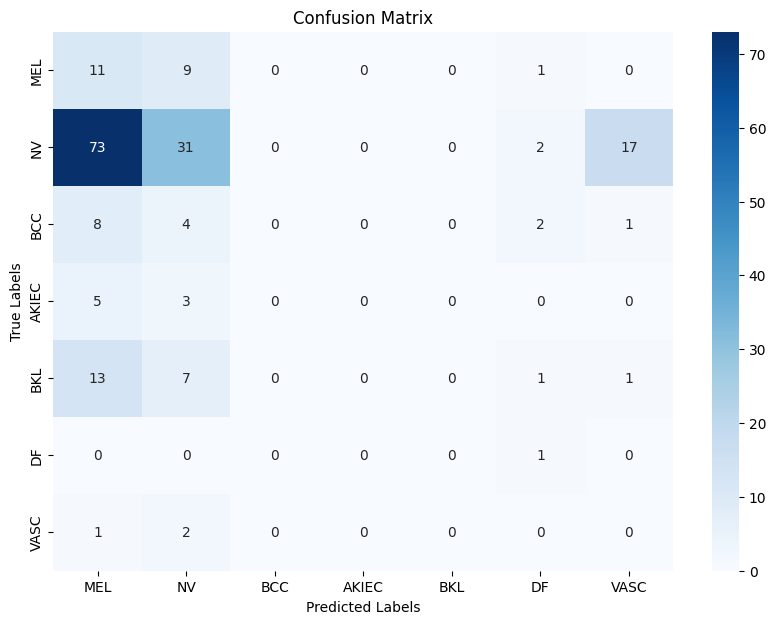

In [11]:
if len(y_true_idx) > 0:
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()
else:
    print("Skipping confusion matrix heatmap as no valid data is available.")

## 11. Visualize Class Distribution (Ground Truth)
Create a bar chart to show the distribution of samples across different classes in the ground truth data. This helps in identifying class imbalances.

/tmp/ipykernel_19767/3411513382.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')


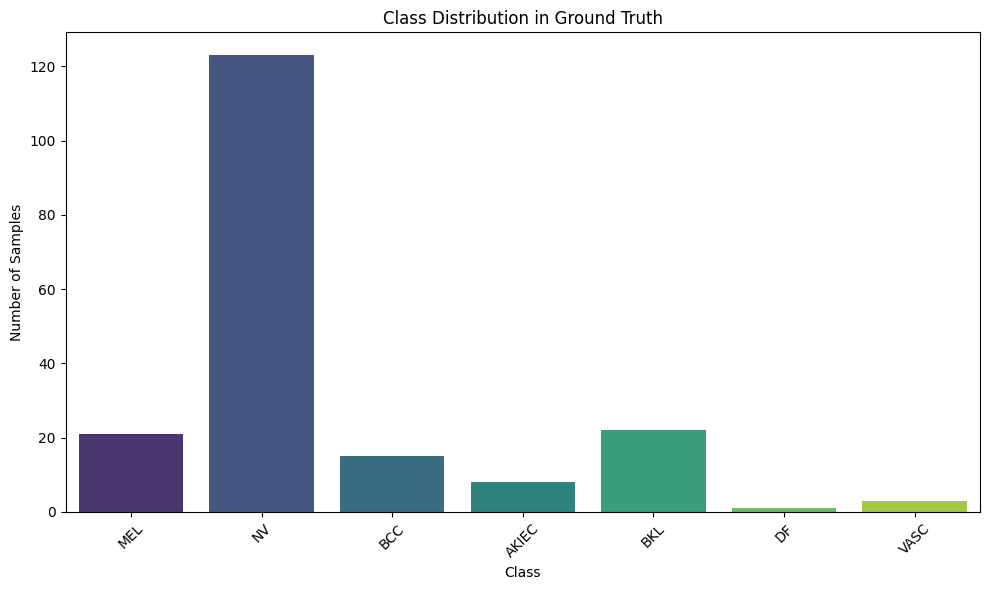


Class Distribution in Ground Truth:
  MEL: 21 (10.88%)
  NV: 123 (63.73%)
  BCC: 15 (7.77%)
  AKIEC: 8 (4.15%)
  BKL: 22 (11.40%)
  DF: 1 (0.52%)
  VASC: 3 (1.55%)


In [12]:
if len(y_true_report) > 0:
    class_counts = pd.Series(y_true_report).value_counts().reindex(classes, fill_value=0)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')
    plt.xlabel('Class')
    plt.ylabel('Number of Samples')
    plt.title('Class Distribution in Ground Truth')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    print('\nClass Distribution in Ground Truth:')
    for cls, count in class_counts.items():
        percentage = count / len(y_true_report) * 100 if len(y_true_report) > 0 else 0
        print(f'  {cls}: {count} ({percentage:.2f}%)')
else:
    print("Skipping class distribution plot as no valid data is available.")

## 12. Visualize Class-specific Accuracy
Display a bar chart showing the accuracy for each individual class.

/tmp/ipykernel_19767/4082099836.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_accuracy_series.index, y=class_accuracy_series.values, palette='coolwarm')


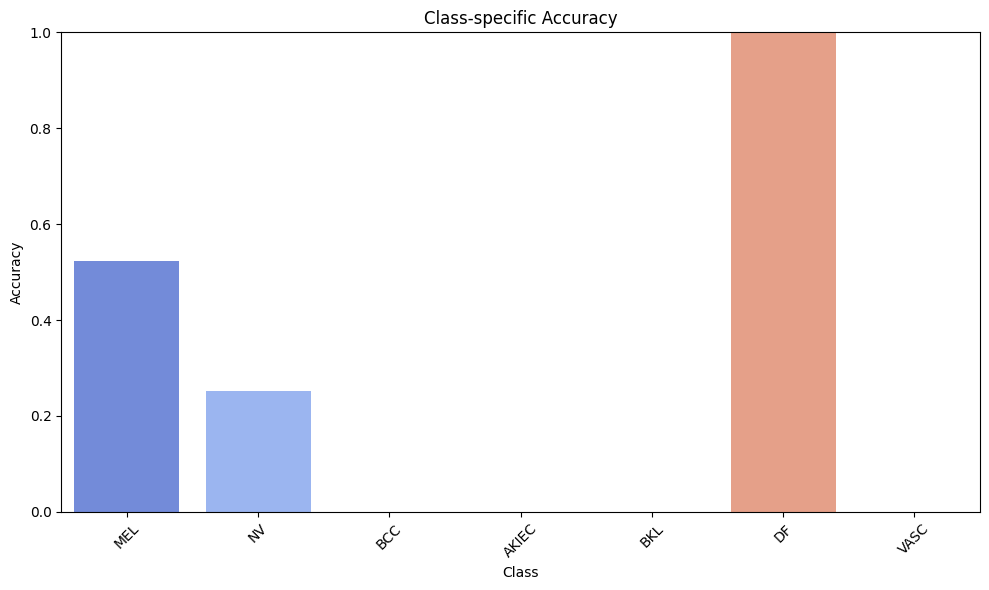


Class-specific Accuracy:
  MEL: 0.5238 (11/21)
  NV: 0.2520 (31/123)
  BCC: 0.0000 (0/15)
  AKIEC: 0.0000 (0/8)
  BKL: 0.0000 (0/22)
  DF: 1.0000 (1/1)
  VASC: 0.0000 (0/3)


In [13]:
if len(y_true_idx) > 0:
    class_accuracy = {}
    for i, cls_name in enumerate(classes):
        # Indices where true label is the current class
        cls_true_indices = [j for j, label_idx in enumerate(y_true_idx) if label_idx == i]
        if cls_true_indices:
            correct_predictions = sum(1 for k in cls_true_indices if y_pred_idx[k] == i)
            accuracy_for_class = correct_predictions / len(cls_true_indices)
            class_accuracy[cls_name] = accuracy_for_class
        else:
            class_accuracy[cls_name] = 0.0 # Or np.nan if you prefer

    class_accuracy_series = pd.Series(class_accuracy).reindex(classes, fill_value=0)

    plt.figure(figsize=(10, 6))
    sns.barplot(x=class_accuracy_series.index, y=class_accuracy_series.values, palette='coolwarm')
    plt.xlabel('Class')
    plt.ylabel('Accuracy')
    plt.title('Class-specific Accuracy')
    plt.xticks(rotation=45)
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.show()

    print('\nClass-specific Accuracy:')
    for cls_name, acc in class_accuracy_series.items():
        cls_true_indices = [j for j, label_idx in enumerate(y_true_idx) if label_idx == class_to_idx[cls_name]]
        correct_predictions = sum(1 for k in cls_true_indices if y_pred_idx[k] == class_to_idx[cls_name])
        total_cls_samples = len(cls_true_indices) if cls_true_indices else 0
        print(f'  {cls_name}: {acc:.4f} ({correct_predictions}/{total_cls_samples})')
else:
    print("Skipping class-specific accuracy plot as no valid data is available.")

## 13. Visualize Precision, Recall, F1-score per Class
Create a grouped bar chart to compare precision, recall, and F1-score for each class. This provides a comprehensive view of per-class performance.

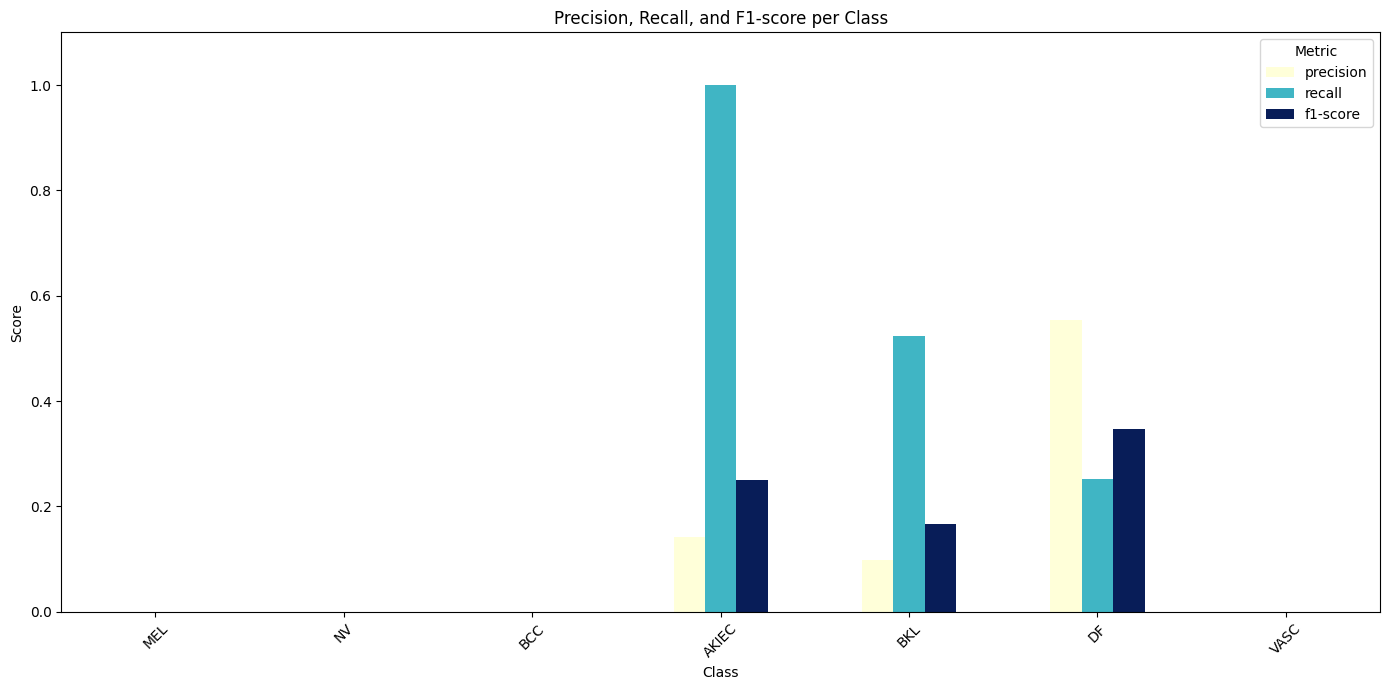

In [14]:
if len(y_true_idx) > 0:
    try:
        report = classification_report(y_true_report, y_pred_report, target_names=classes, output_dict=True, zero_division=0)
        # Remove aggregate keys like 'accuracy', 'macro avg', 'weighted avg'
        class_metrics = {k: report[k] for k in classes if k in report} 
        
        metrics_df = pd.DataFrame(class_metrics).T[['precision', 'recall', 'f1-score']]
        
        if not metrics_df.empty:
            metrics_df.plot(kind='bar', figsize=(14, 7), colormap='YlGnBu')
            plt.title('Precision, Recall, and F1-score per Class')
            plt.ylabel('Score')
            plt.xlabel('Class')
            plt.xticks(rotation=45)
            plt.legend(title='Metric')
            plt.ylim(0, 1.1) # Set y-limit to better visualize scores, slightly above 1.0 for legend
            plt.tight_layout()
            plt.show()
        else:
            print("No per-class metrics available to plot (metrics_df is empty).")

    except Exception as e:
        print(f"Could not generate or plot per-class metrics: {e}")
else:
    print("Skipping per-class metrics plot as no valid data is available.")